In [615]:
# this implements the article:
# https://openreview.net/forum?id=ogXkmugNZw

import gymnasium as gym
import torch
from matplotlib import pyplot as plt
import mo_gymnasium as mo_gym
import numpy as np
import cvxpy as cp
from torch.nn.utils import vector_to_parameters, parameters_to_vector
from cleanrl.cleanrl.ppo import layer_init
import os
import random
import time
from dataclasses import dataclass
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical
from torch.utils.tensorboard import SummaryWriter
from copy import deepcopy

In [555]:
def grads_to_vector(model):
    return parameters_to_vector((p.grad for p in model.parameters()))

In [556]:
model = nn.Linear(32, 32)

In [557]:
sm2 = sum((p**2).sum() for p in model.parameters())

In [558]:
list(model.parameters())[0].grad

In [559]:
sm2.backward()

In [560]:
list(model.parameters())[0].grad

tensor([[-0.3123,  0.3319,  0.3117,  ...,  0.2402, -0.2830,  0.1091],
        [-0.1886, -0.1460, -0.0630,  ...,  0.1006,  0.0147, -0.0955],
        [ 0.1421,  0.1432,  0.2764,  ...,  0.3140, -0.0456,  0.1514],
        ...,
        [ 0.3258, -0.2577, -0.2903,  ...,  0.1224,  0.0081,  0.0059],
        [-0.0502,  0.2860,  0.3041,  ...,  0.0906, -0.1949, -0.3125],
        [ 0.0957, -0.2784, -0.1635,  ..., -0.1951,  0.2582, -0.1390]])

In [561]:
grads_to_vector(model)

tensor([-0.3123,  0.3319,  0.3117,  ..., -0.0672,  0.1565, -0.0037])

In [562]:
p1.grad

/var/folders/pj/kc0mj8fx5ks38zy3t9nbjfdh0000gn/T/ipykernel_1074/3950772375.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729647038473/work/build/aten/src/ATen/core/TensorBody.h:494.)
  p1.grad


In [563]:
p1 = torch.Tensor([1., 2., 3.])
p2 = torch.tensor([4., 5., 6.], requires_grad=True)

In [564]:
p1 = fuse_parameters(model)

In [565]:
sm2 = sum((p**2).sum() for p in model.parameters())
sm2

tensor(10.8917, grad_fn=<AddBackward0>)

In [566]:
sm2.backward()

In [567]:
p1.grad

/var/folders/pj/kc0mj8fx5ks38zy3t9nbjfdh0000gn/T/ipykernel_1074/3950772375.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729647038473/work/build/aten/src/ATen/core/TensorBody.h:494.)
  p1.grad


In [568]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.1561,  0.1659,  0.1559,  ...,  0.1201, -0.1415,  0.0546],
         [-0.0943, -0.0730, -0.0315,  ...,  0.0503,  0.0074, -0.0478],
         [ 0.0711,  0.0716,  0.1382,  ...,  0.1570, -0.0228,  0.0757],
         ...,
         [ 0.1629, -0.1288, -0.1451,  ...,  0.0612,  0.0041,  0.0029],
         [-0.0251,  0.1430,  0.1520,  ...,  0.0453, -0.0974, -0.1562],
         [ 0.0479, -0.1392, -0.0818,  ..., -0.0976,  0.1291, -0.0695]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.1095,  0.0144,  0.1647, -0.0086, -0.0396,  0.0281, -0.0955, -0.0587,
          0.0300,  0.1699, -0.1110,  0.1392, -0.0874,  0.0520,  0.1323, -0.1125,
         -0.0810,  0.1744,  0.0987, -0.1072, -0.0142,  0.0640, -0.0402, -0.1437,
          0.0624, -0.0652, -0.0329,  0.0363, -0.0160, -0.0336,  0.0782, -0.0018],
        requires_grad=True)]

In [569]:
torch.sum(p2)

tensor(15., grad_fn=<SumBackward0>)

In [570]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.1561,  0.1659,  0.1559,  ...,  0.1201, -0.1415,  0.0546],
         [-0.0943, -0.0730, -0.0315,  ...,  0.0503,  0.0074, -0.0478],
         [ 0.0711,  0.0716,  0.1382,  ...,  0.1570, -0.0228,  0.0757],
         ...,
         [ 0.1629, -0.1288, -0.1451,  ...,  0.0612,  0.0041,  0.0029],
         [-0.0251,  0.1430,  0.1520,  ...,  0.0453, -0.0974, -0.1562],
         [ 0.0479, -0.1392, -0.0818,  ..., -0.0976,  0.1291, -0.0695]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.1095,  0.0144,  0.1647, -0.0086, -0.0396,  0.0281, -0.0955, -0.0587,
          0.0300,  0.1699, -0.1110,  0.1392, -0.0874,  0.0520,  0.1323, -0.1125,
         -0.0810,  0.1744,  0.0987, -0.1072, -0.0142,  0.0640, -0.0402, -0.1437,
          0.0624, -0.0652, -0.0329,  0.0363, -0.0160, -0.0336,  0.0782, -0.0018],
        requires_grad=True)]

In [571]:
def fuse_parameters(model):
    """Move model parameters to a contiguous tensor, and return that tensor."""
    n = sum(p.numel() for p in model.parameters())
    params = torch.zeros(n)
    i = 0
    for p in model.parameters():
        params_slice = params[i:i + p.numel()]
        params_slice.copy_(p.flatten())
        i += p.numel()
    i = 0
    params.requires_grad_()
    for p in model.parameters():
        params_slice = params[i:i + p.numel()]
        p.data = params_slice.view(p.shape).requires_grad_()
        i += p.numel()
    return params

In [572]:
# https://stackoverflow.com/a/74866633
def fuse_parameters_and_gradients(model):
    """Move model parameters and gradients to a contiguous tensor, and return that tensor."""
    n = sum(p.numel() for p in model.parameters())
    params = torch.zeros(n, requires_grad=True)
    params.grad = torch.zeros(n)
    i = 0
    for p in model.parameters():
        params_slice = params[i:i + p.numel()]
        with torch.no_grad(): params_slice.copy_(p.flatten())
        p.data = params_slice.view(p.shape)
        p.grad = params.grad[i:i + p.numel()].view(p.shape)
        i += p.numel()
    return params

# fuse_parameters_and_gradients = fuse_parameters

In [573]:
def cat_saw(x, a, w):
    return torch.hstack((x.flatten(), a, w.flatten()))

def cat_sw(x, w):
    return torch.hstack((x.flatten(), w.flatten()))

In [841]:
# Agent mostly copied from https://github.com/vwxyzjn/cleanrl/blob/master/cleanrl/ppo.py and changed a bit
class Agent(nn.Module):
    def __init__(self, envs, costs, rewards):
        super().__init__()
        self.envs = envs
        self.costs = costs
        self.rewards = rewards
        actions = 1  # single action possible
        observations = np.array(envs.observation_space.shape).prod()
        
        self.reward_critics = [nn.Sequential(
            layer_init(nn.Linear(observations + actions + rewards, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 1), std=1.0),
        ) for _ in range(rewards)]
        
        self.cost_critics = [nn.Sequential(
            layer_init(nn.Linear(observations + actions + rewards, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 1), std=1.0),
        ) for _ in range(costs)]
        
        self.actor = nn.Sequential(
            layer_init(nn.Linear(observations + rewards, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, envs.action_space.n), std=0.01),
        )

        # self.reward_params = [fuse_parameters_and_gradients(critic) for critic in self.reward_critics]
        # self.cost_params = [fuse_parameters_and_gradients(critic) for critic in self.cost_critics]
        # self.actor_params = fuse_parameters_and_gradients(self.actor)

    def set_w(self, weights):
        self.weights = deepcopy(weights)

    def __deepcopy__(self, memo):
        with torch.no_grad():
            copied = Agent(*map(deepcopy, (self.envs, self.costs, self.rewards)))
            copied.reward_critics, copied.cost_critics, copied.actor = \
                deepcopy([self.reward_critics, self.cost_critics, self.actor])
            copied.weights = deepcopy(self.weights)
            copied.actor = deepcopy(self.actor)
        # copied.reward_params = [fuse_parameters_and_gradients(critic) for critic in copied.reward_critics]
        # copied.cost_params = [fuse_parameters_and_gradients(critic) for critic in copied.cost_critics]
        # copied.actor_params = fuse_parameters_and_gradients(copied.actor)
        return copied
    
    def get_optim_critic(self):
        return [x for critic in self.reward_critics for x in critic.parameters()] + \
               [x for critic in self.cost_critics for x in critic.parameters()]

    def get_optim_actor(self):
        return list(self.actor.parameters())

    def get_value(self, x):
        return self.critic(x)

    def get_probs(self, x, w=None):
        if w is None:
            w = self.weights
        logits = self.actor(cat_sw(x, w))
        return torch.softmax(logits, -1)

    def get_action_and_value(self, x, w=None, action=None):
        if w is None:
            w = self.weights
        logits = self.actor(cat_sw(x, w))
        # print(x)
        probs = Categorical(logits=logits)
        
        if action is None:
            action = probs.sample()
        criticised = cat_saw(x, action, w)
        return (action, 
                probs.log_prob(action),
                probs.entropy(), 
                torch.cat([critic(criticised) for critic in self.reward_critics]),
                torch.cat([critic(criticised) for critic in self.cost_critics])
               )


In [739]:
# # Agent mostly copied from https://github.com/vwxyzjn/cleanrl/blob/master/cleanrl/ppo.py and changed a bit
# class Agent(nn.Module):
#     def __init__(self, envs):
#         super().__init__()
#         self.critic = nn.Sequential(
#             layer_init(nn.Linear(np.array(envs.observation_space.shape).prod(), 64)),
#             nn.Tanh(),
#             layer_init(nn.Linear(64, 64)),
#             nn.Tanh(),
#             layer_init(nn.Linear(64, 1), std=1.0),
#         )
#         self.actor = nn.Sequential(
#             layer_init(nn.Linear(np.array(envs.observation_space.shape).prod(), 64)),
#             nn.Tanh(),
#             layer_init(nn.Linear(64, 64)),
#             nn.Tanh(),
#             layer_init(nn.Linear(64, envs.action_space.n), std=0.01),
#         )

#     def get_value(self, x):
#         return self.critic(x)

#     def get_action_and_value(self, x, action=None):
#         logits = self.actor(x)
#         # print(logits)
#         probs = Categorical(logits=logits)
#         if action is None:
#             action = probs.sample()
#         return action, probs.log_prob(action), probs.entropy(), self.critic(x)

In [740]:
from gymnasium.wrappers import numpy_to_torch


import functools
import numbers
from collections import abc
from typing import Any, Iterable, Mapping, SupportsFloat, Union

import numpy as np

import gymnasium as gym
from gymnasium.core import RenderFrame, WrapperActType, WrapperObsType
from gymnasium.error import DependencyNotInstalled

In [741]:
class Frame:
    def __init__(self, s, a, r, c, sp, rpred, cpred):
        self.s = s
        self.a = a
        self.r = r
        self.c = c
        self.sp = sp
        self.rpred = rpred
        self.cpred = cpred

In [742]:
# slightly adjusts the gymnasium wrapper to support MO
class MONumpyToTorch(numpy_to_torch.NumpyToTorch):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def set_w(self, w):
        w = np.array(w)
        assert np.allclose(np.max(w), 1) and np.min(w) >= 1e-7
        self.w = w

    def step(
        self, action: WrapperActType
    ) -> tuple[WrapperObsType, SupportsFloat, bool, bool, dict]:
        """Using a PyTorch based action that is converted to NumPy to be used by the environment.

        Args:
            action: A PyTorch-based action

        Returns:
            The PyTorch-based Tensor next observation, reward, termination, truncation, and extra info
        """
        jax_action = numpy_to_torch.torch_to_numpy(action)
        obs, reward, terminated, truncated, info = self.env.step(jax_action)

        return (
            numpy_to_torch.numpy_to_torch(obs, self.device),
            np.float64(reward),
            bool(terminated),
            bool(truncated),
            numpy_to_torch.numpy_to_torch(info, self.device),
        )

In [725]:
def cost_1(obs, action, obs_new):
    if action != 1 and action != 2:
        return 0
    return obs[-1] + obs[-2]

def cost_2(obs, action, obs_new):
    if action != 0:
        return 0
    return (1 - obs[0]) ** 2 + (1 - obs[1]) ** 2

def cost_func(obs, action, obs_new):
    return torch.tensor((cost_1(obs, action, obs_new), cost_2(obs, action, obs_new)))

In [726]:
def YRi(reward_critics, frame : Frame, frame2 : Frame, i, gamma, w):
    return frame.r[i] + gamma * reward_critics[i](cat_saw(frame.sp, frame2.a, w))

def YCi(cost_critics, frame : Frame, frame2 : Frame, i, gamma, w):
    return frame.c[i] + gamma * cost_critics[i](cat_saw(frame.sp, frame2.a, w))

def obj_R(critics, taus, gamma, ws):
    n = len(critics)
    v = 0
    s_ln = 0
    for ti, tau in enumerate(taus):
        w = ws[ti]
        obss = len(tau) - 1
        s_ln += obss
        for oi in range(obss):
            for i in range(n):
                frame = tau[oi]
                v += (YRi(critics, tau[oi], tau[oi + 1], i, gamma, w) - critics[i](cat_saw(frame.s, frame.a, w))) ** 2
    return v / s_ln


def obj_C(critics, taus, gamma, ws):
    n = len(critics)
    v = 0
    s_ln = 0
    for ti, tau in enumerate(taus):
        w = ws[ti]
        obss = len(tau) - 1
        s_ln += obss
        for oi in range(obss):
            for i in range(n):
                frame = tau[oi]
                v += (YCi(critics, tau[oi], tau[oi + 1], i, gamma, w) - critics[i](cat_saw(frame.s, frame.a, w))) ** 2
    return v / s_ln

In [727]:
def avg_critics(critics, taus, gamma, ws):
    n = len(critics)
    v = 0
    s_ln = 0
    for ti, tau in enumerate(taus):
        w = ws[ti]
        obss = len(tau)
        s_ln += obss
        for oi in range(obss):
            for i in range(n):
                frame = tau[oi]
                v += critics[i](cat_saw(frame.s, frame.a, w))
    return v / s_ln


In [907]:
# i am not too fluent with cvxpy, so LLM was used for this
def get_dual_multipliers(g, b, c, d, eps, H_inv=None):
    if H_inv is None:
        H_inv_np = np.eye(g.shape[1])
    else:
        H_inv_np = H_inv.detach().numpy()
    g_np = g.detach().numpy()
    b_np = b.detach().numpy()
    e = eps * np.linalg.norm(g_np, axis=1)
    w_e_np = (w * e).detach().numpy()
    c_m_d_np = (c - d).detach().numpy()
    n = g_np.shape[0]
    m = b_np.shape[0]
    
    nu = cp.Variable(n, nonneg=True)
    lmbd = cp.Variable(m, nonneg=True)
    
    quad = cp.quad_form(cp.sum([nu[i] * g_np[i] for i in range(n)]) - 
                        cp.sum([lmbd[k] * b_np[k] for k in range(m)]), H_inv_np)
    objective = -0.5 * quad + cp.sum(nu @ w_e_np) + cp.sum(lmbd @ c_m_d_np)
    
    # Solve
    problem = cp.Problem(cp.Maximize(objective))
    problem.solve()
    
    nu_star = torch.tensor(nu.value)
    lmbd_star = torch.tensor(lmbd.value)
    return nu_star, lmbd_star

In [908]:
cp.SCS

'SCS'

In [909]:
# I tried to LLM this for a pretty solution but seems there's none

def grad_forward(g, model):
    pointer = 0
    for param in model.parameters():
        num_param = param.numel()  # Number of elements in the parameter
        # Slice the gradient vector to match the parameter's shape
        param_grad = g[pointer : pointer + num_param].view_as(param)
        param.grad = param_grad  # Assign gradient
        pointer += num_param  # Move pointer
    
    # Verify that all gradients were assigned
    assert pointer == len(g), "Gradient vector length does not match total parameters!"


In [910]:
# I do have the idea for this but too lazy to write at night. LLMed
def compute_kl_divergence(agent_probs, pi_w_probs):
    """
    Compute KL(pi_w || agent) using pre-computed probability buffers
    
    Args:
        agent_probs: Pprobs for niversal policy network (π_θ)
        pi_w_probs: Probs for intermediate policy network (π_ω)
    
    Returns:
        kl_div: Scalar KL divergence loss
    """

    # Add small epsilon to avoid log(0)
    eps = 1e-8
    pi_w_probs = pi_w_probs.clamp(min=eps)
    agent_probs = agent_probs.clamp(min=eps)
    
    # Compute KL divergence: Σ pi_w_probs * (log(pi_w_probs) - log(agent_probs))
    kl_div = (pi_w_probs * (torch.log(pi_w_probs) - torch.log(agent_probs))).sum(dim=1)
    
    # Return mean KL over batch
    return kl_div.mean()

In [969]:
#llm

import matplotlib.pyplot as plt
import numpy as np
from time import sleep

# Set up interactive mode

%matplotlib inline
def get_lines(xlim, ylim, cnt, rew_bound=3, nograd_bnd=5):
    plt.ion()  # Turn on interactive mode
    fig, ax = plt.subplots()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Progressive Plot Building')
    lines = []
    datas = []
    for _ in range(cnt):
        col = ('b' if _ < rew_bound else 'r')
        if _ >= nograd_bnd:
            col = 'g'
        line, = ax.plot([], [], col + '-')  # Empty line object
        datas.append([[], []])
        lines.append(line)
        
    # Set axis limits (adjust according to your expected data range)
    # ax.set_xlim(*xlim)
    # ax.set_ylim(*ylim)
    # plt.show()
    return fig, ax, datas, lines

def add_val(fig, ax, datas, lines, xs, ys):
    assert len(lines) == len(xs)
    for i in range(len(lines)):
        x_data, y_data = datas[i]
        line = lines[i]
        x = xs[i]
        y = ys[i]
        
        # Append new data
        x_data.append(x)
        y_data.append(y)
        
        # Update plot data
        line.set_xdata(x_data)
        line.set_ydata(y_data)
        
        # Adjust view if needed
        ax.relim()  # Recalculate limits
        ax.autoscale_view()  # Auto-scale
        
        # Redraw the plot
    fig.canvas.draw()
    fig.canvas.flush_events()
    # plt.show()
    # plt.ion()
    plt.draw()
    
        

# # Keep the window open after completion
# plt.ioff()
# plt.show()

In [970]:
_

tensor(1.7602, grad_fn=<NegBackward0>)

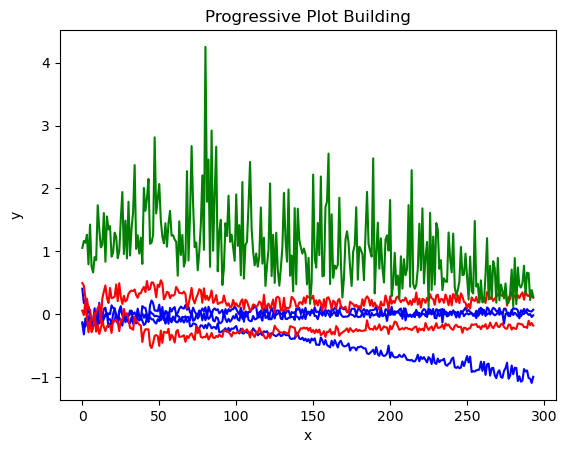

RuntimeError: Could not infer dtype of NoneType

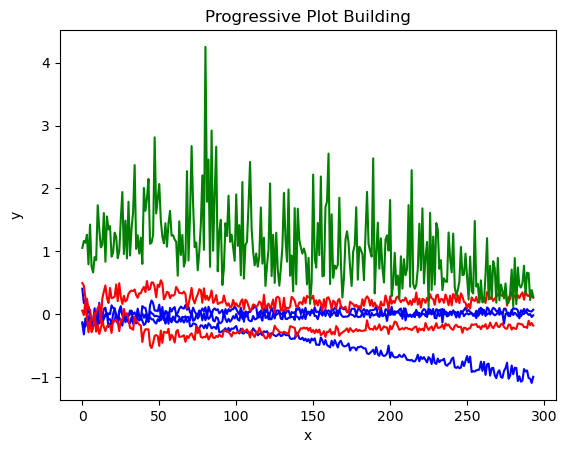

In [995]:
#example from mo_gymnasium, adjusted
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output
from time import sleep

env = mo_gym.make('minecart-v0')
env = MONumpyToTorch(env)

obs_n = env.observation_space.shape[0]
rew_n = 3  # idk how to get it from env
cost_n = 2
d = torch.Tensor([10] * cost_n)
L = 3
T = 300
P = 3

ITERS = 300
lambda_max = 10000
g_min = 1e-9
g_max = 10000
eps_local_s = 50

gamma = 0.99

C1 = 10**9
C2 = 10**9

env.set_w([1] * rew_n)

agent = Agent(env, cost_n, rew_n)
agent.set_w(env.w)

param_cnt = sum(p.numel() for p in agent.actor.parameters())

optim_critic = torch.optim.AdamW(agent.get_optim_critic(), lr=0.001)
optim_policy = torch.optim.AdamW(agent.get_optim_actor(), lr=0.001)

fig, ax, datas, lines = get_lines((0, 30), (-5, 5), 6)
display(fig)


for ITER_NUM in range(ITERS):
    eps_local = eps_local_s / (ITER_NUM + 1)
    clear_output(wait=True)
    display(fig)
    ws = []
    taus = []
    for rollout in range(L):
        
        w = torch.rand(size=(rew_n,))
        w /= torch.max(w)
        ws.append(w)
        env.set_w(w)
        agent.set_w(env.w)
        
        obs, info = env.reset()
        
        episode_over = False
        t = 0
        tau = []
        while not episode_over and t < T:
            t += 1
            action, _, _, rpred, cpred = agent.get_action_and_value(obs, w)
            obs_new, reward, terminated, truncated, info = env.step(action)
            costs = cost_func(obs, action, obs_new)
            episode_over = terminated or truncated
            tau.append(Frame(obs, action, reward, costs, obs_new, rpred, cpred))
            obs = obs_new
        taus.append(tau)
    
    o_R = obj_R(agent.reward_critics, taus, gamma, ws)
    o_C = obj_C(agent.cost_critics, taus, gamma, ws)
    
    optim_critic.zero_grad()
    o_R.backward()
    o_C.backward()
    optim_critic.step()
    # ws = []
    # taus = []
    
    pi_ws = []
    
    div_kl = 0
    for p in range(P):
        w = torch.rand(size=(rew_n,))
        w /= torch.max(w)
    
        
        env.set_w(w)
        pi_w = deepcopy(agent)
        pi_w.set_w(w)
        # pi_w.actor_params.requires_grad_()
        # pi_w.actor.requires_grad_()
    
        # for param in pi_w.actor.parameters():
        #     param.requires_grad_()
        
        obs, info = env.reset()
        
        episode_over = False
        t = 0
        tau = []
        pwp = parameters_to_vector(pi_w.actor.parameters())
        pwp.requires_grad_()
        # pwp = torch.nn.Parameter(pwp, requires_grad=True)
        g_i = torch.zeros((rew_n, param_cnt))
        b_i = torch.zeros((cost_n, param_cnt))
        JR_i = torch.zeros((rew_n,))
        JC_i = torch.zeros((cost_n,))
        while not episode_over and t < T:
            t += 1
            action, a_prob, entropy, rpred, cpred = pi_w.get_action_and_value(obs, w)
            obs_new, reward, terminated, truncated, info = env.step(action)
            costs = cost_func(obs, action, obs_new)
    
            a_grad = parameters_to_vector(torch.autograd.grad(a_prob, pi_w.actor.parameters()))
            
            g_i += rpred[:, None] @ a_grad[None, :]
            b_i += cpred[:, None] @ a_grad[None, :]
            JR_i += rpred
            JC_i += cpred
                # a_grads = torch.autograd.grad(a_prob
                # g_i[i] += costs
            
            episode_over = terminated or truncated
            tau.append(Frame(obs, action, reward, costs, obs_new, rpred, cpred))
            obs = obs_new
        g_i /= t
        b_i /= t
        JR_i /= t
        JC_i /= t
    
        nu, lmbd = get_dual_multipliers(g_i, b_i, JC_i, d, eps_local)
    
        lmbd_sum = sum(lmbd)
    
        g_ag_w = None
        if (JC_i <= d).all():
            nu_sum = sum(nu)
            term_1 = sum(nu[i] / nu_sum * g_i[i] for i in range(rew_n))
    
            #maybe its sum lambda below?
            lmbd_mod = torch.minimum(lmbd / eps_local / nu_sum, torch.ones(lmbd.shape) * lambda_max)
            term_2 = eps_local * sum(lmbd_mod[k] * b_i[k] for k in range(cost_n))
    
            g_est_ag_w = term_1 - term_2
        else:
            g_est_ag_w = -sum(lmbd[k] / lmbd_sum * b_i[k] for k in range(cost_n))
        g_ag_w = eps_local * g_est_ag_w / min(max(torch.norm(g_est_ag_w), g_min), g_max)
        # vector_to_parameters(g_ag_w, [p.grad for p in pi_w.actor.parameters()])
        
        grad_forward(g_ag_w, pi_w.actor)
        with torch.no_grad():
            for p in pi_w.actor.parameters():
                p += p.grad
        pi_ws.append(pi_w)
        
        pi_w_probs = torch.cat([pi_w.get_probs(frame.s, w)[None, :] for frame in tau])
        agent_probs = torch.cat([agent.get_probs(frame.s, w)[None, :] for frame in tau])
        
        divergence = compute_kl_divergence(agent_probs, pi_w_probs)
    
        div_kl += divergence
    div_kl /= P
    optim_policy.zero_grad()
    div_kl.backward()
    
    add_val(fig, ax, datas, lines, [ITER_NUM] * 6, np.concatenate(
        (JR_i.detach().numpy(),
         JC_i.detach().numpy(),
         np.linalg.norm(grads_to_vector(agent.actor).detach().numpy())[None])))
    optim_policy.step()
    
env.close()

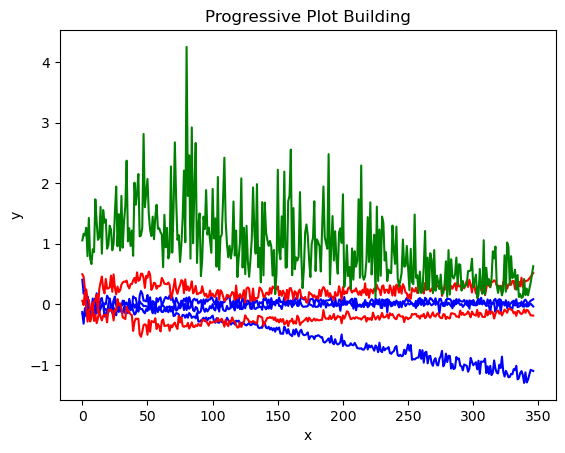

In [ ]:
env = mo_gym.make('minecart-v0', render_mode='human')
env = MONumpyToTorch(env)

for ITER_NUM in range(ITER_NUM + 1, ITERS + 300):
    try:
        eps_local = eps_local_s / (ITER_NUM + 1)
        clear_output(wait=True)
        display(fig)
        ws = []
        taus = []
        for rollout in range(L):
            
            w = torch.rand(size=(rew_n,))
            w /= torch.max(w)
            ws.append(w)
            env.set_w(w)
            agent.set_w(env.w)
            
            obs, info = env.reset()
            
            episode_over = False
            t = 0
            tau = []
            while not episode_over and t < T:
                t += 1
                action, _, _, rpred, cpred = agent.get_action_and_value(obs, w)
                obs_new, reward, terminated, truncated, info = env.step(action)
                costs = cost_func(obs, action, obs_new)
                episode_over = terminated or truncated
                tau.append(Frame(obs, action, reward, costs, obs_new, rpred, cpred))
                obs = obs_new
            taus.append(tau)
        
        o_R = obj_R(agent.reward_critics, taus, gamma, ws)
        o_C = obj_C(agent.cost_critics, taus, gamma, ws)
        
        optim_critic.zero_grad()
        o_R.backward()
        o_C.backward()
        optim_critic.step()
        # ws = []
        # taus = []
        
        pi_ws = []
        
        div_kl = 0
        for p in range(P):
            w = torch.rand(size=(rew_n,))
            w /= torch.max(w)
        
            
            env.set_w(w)
            pi_w = deepcopy(agent)
            pi_w.set_w(w)
            # pi_w.actor_params.requires_grad_()
            # pi_w.actor.requires_grad_()
        
            # for param in pi_w.actor.parameters():
            #     param.requires_grad_()
            
            obs, info = env.reset()
            
            episode_over = False
            t = 0
            tau = []
            pwp = parameters_to_vector(pi_w.actor.parameters())
            pwp.requires_grad_()
            # pwp = torch.nn.Parameter(pwp, requires_grad=True)
            g_i = torch.zeros((rew_n, param_cnt))
            b_i = torch.zeros((cost_n, param_cnt))
            JR_i = torch.zeros((rew_n,))
            JC_i = torch.zeros((cost_n,))
            while not episode_over and t < T:
                t += 1
                action, a_prob, entropy, rpred, cpred = pi_w.get_action_and_value(obs, w)
                obs_new, reward, terminated, truncated, info = env.step(action)
                costs = cost_func(obs, action, obs_new)
        
                a_grad = parameters_to_vector(torch.autograd.grad(a_prob, pi_w.actor.parameters()))
                
                g_i += rpred[:, None] @ a_grad[None, :]
                b_i += cpred[:, None] @ a_grad[None, :]
                JR_i += rpred
                JC_i += cpred
                    # a_grads = torch.autograd.grad(a_prob
                    # g_i[i] += costs
                
                episode_over = terminated or truncated
                tau.append(Frame(obs, action, reward, costs, obs_new, rpred, cpred))
                obs = obs_new
            g_i /= t
            b_i /= t
            JR_i /= t
            JC_i /= t
        
            nu, lmbd = get_dual_multipliers(g_i, b_i, JC_i, d, eps_local)
        
            lmbd_sum = sum(lmbd)
        
            g_ag_w = None
            if (JC_i <= d).all():
                nu_sum = sum(nu)
                term_1 = sum(nu[i] / nu_sum * g_i[i] for i in range(rew_n))
        
                #maybe its sum lambda below?
                lmbd_mod = torch.minimum(lmbd / eps_local / nu_sum, torch.ones(lmbd.shape) * lambda_max)
                term_2 = eps_local * sum(lmbd_mod[k] * b_i[k] for k in range(cost_n))
        
                g_est_ag_w = term_1 - term_2
            else:
                g_est_ag_w = -sum(lmbd[k] / lmbd_sum * b_i[k] for k in range(cost_n))
            g_ag_w = eps_local * g_est_ag_w / min(max(torch.norm(g_est_ag_w), g_min), g_max)
            # vector_to_parameters(g_ag_w, [p.grad for p in pi_w.actor.parameters()])
            
            grad_forward(g_ag_w, pi_w.actor)
            with torch.no_grad():
                for p in pi_w.actor.parameters():
                    p += p.grad
            pi_ws.append(pi_w)
            
            pi_w_probs = torch.cat([pi_w.get_probs(frame.s, w)[None, :] for frame in tau])
            agent_probs = torch.cat([agent.get_probs(frame.s, w)[None, :] for frame in tau])
            
            divergence = compute_kl_divergence(agent_probs, pi_w_probs)
        
            div_kl += divergence
        div_kl /= P
        optim_policy.zero_grad()
        div_kl.backward()
        
        add_val(fig, ax, datas, lines, [ITER_NUM] * 6, np.concatenate(
            (JR_i.detach().numpy(),
             JC_i.detach().numpy(),
             np.linalg.norm(grads_to_vector(agent.actor).detach().numpy())[None])))
        optim_policy.step()
    except Exception as e:
        pass

In [980]:
add_val(fig, ax, datas, lines, [ITER_NUM] * 5, np.concatenate(
            (JR_i.detach().numpy(),
             JC_i.detach().numpy(),
             np.linalg.norm(grads_to_vector(agent.actor).detach().numpy())[None])))

<Figure size 640x480 with 0 Axes>

In [973]:
np.linalg.norm(grads_to_vector(agent.actor).detach().numpy())

0.9154415

In [989]:
list(agent.reward_critics[1].parameters())

[Parameter containing:
 tensor([[-1.1350e-01, -3.1762e-01,  1.1970e-01, -1.0288e-01, -2.5212e-01,
          -4.1129e-01, -2.9717e-02,  1.0195e-01, -9.4691e-02,  1.8385e-02,
           5.7578e-02],
         [ 2.6270e-01, -4.9572e-02,  1.3742e-01,  2.8842e-02,  2.0640e-02,
          -9.1235e-02,  1.4541e-01,  1.1383e-03,  1.1316e-01,  2.1540e-01,
          -7.2899e-02],
         [-1.3258e-01, -2.3760e-01, -1.3893e-01,  1.8768e-01,  9.2775e-02,
           1.9432e-01,  2.3526e-02,  2.0702e-02,  2.0165e-02,  7.0703e-03,
          -2.2237e-01],
         [ 1.1237e-01,  1.7045e-01, -2.3528e-02,  2.9238e-02, -1.8419e-01,
          -4.8926e-02,  1.6629e-01, -4.1074e-02,  1.4598e-01, -1.8760e-01,
           4.6650e-01],
         [-2.4172e-01,  1.1672e-01, -9.0408e-02, -4.6531e-02,  9.5405e-02,
          -3.0008e-01, -2.6098e-02, -1.0838e-01,  7.0202e-02, -3.5641e-01,
          -1.9250e-01],
         [-1.0090e-01, -1.0795e-01,  3.3923e-01,  2.8897e-01, -7.0445e-03,
          -3.0321e-01, -2.2932e-

In [961]:
JC_i

tensor([-0.1900,  0.2348], grad_fn=<DivBackward0>)

In [ ]:

    add_val(fig, ax, datas, lines, [ITER_NUM] * 5, [ITER_NUM * i for i in range(5)])

In [ ]:
torch.autograd.grad(divergence, agent.actor.parameters())

In [ ]:
agent_probs

In [858]:
torch.max(JC_i)

tensor(-0.2547, grad_fn=<MaxBackward1>)

In [844]:
nu, lmbd

(tensor([ 2.1107,  2.9348, 90.5923], dtype=torch.float64),
 tensor([1.7689e-06, 0.0000e+00], dtype=torch.float64))

In [649]:
np.linalg.matrix_rank(b_i.detach().numpy())

2

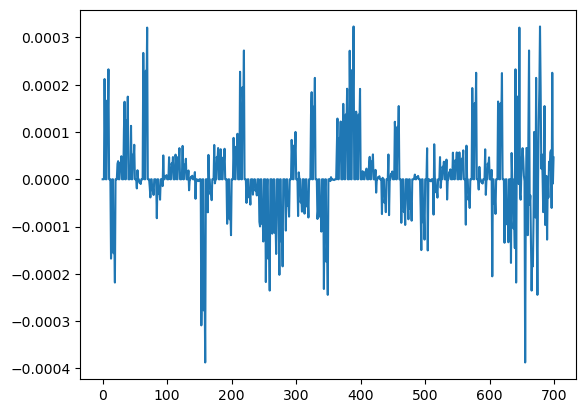

In [650]:
plt.plot(np.arange(g_i.shape[1])[:700], g_i.detach().numpy().mean(axis=0)[:700])

In [608]:
a_grad.shape

torch.Size([5254])

In [610]:
torch.cat(rpred)[:, None] @ a_grad[None, :]

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0752,  0.0756,  0.0749],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0520, -0.0523, -0.0518],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0355, -0.0357, -0.0353]],
       grad_fn=<MmBackward0>)

In [597]:
parameters_to_vector(torch.autograd.grad(a_prob, pi_w.actor.parameters()))

tensor([ 0.0000,  0.0000,  0.0000,  ..., -0.1666, -0.1671, -0.1662])

In [467]:
a_prob.backward(create_graph=True)

/Users/a2mogus/anaconda3/lib/python3.11/site-packages/torch/autograd/graph.py:825: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729647038473/work/torch/csrc/autograd/engine.cpp:1206.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [464]:
pwp.grad

/var/folders/pj/kc0mj8fx5ks38zy3t9nbjfdh0000gn/T/ipykernel_1074/1872387454.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729647038473/work/build/aten/src/ATen/core/TensorBody.h:494.)
  pwp.grad


In [ ]:
pwp.

In [455]:
list(pi_w.actor.parameters())[0].grad

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  7.2242e-04,  7.2242e-04,
          0.0000e+00,  0.0000e+00,  1.0217e-03,  4.2973e-04,  1.6965e-04],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -1.6578e-03, -1.6578e-03,
          0.0000e+00,  0.0000e+00, -2.3445e-03, -9.8617e-04, -3.8933e-04],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -7.0862e-04, -7.0862e-04,
          0.0000e+00,  0.0000e+00, -1.0021e-03, -4.2152e-04, -1.6642e-04],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -4.0667e-04, -4.0667e-04,
          0.0000e+00,  0.0000e+00, -5.7512e-04, -2.4191e-04, -9.5504e-05],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  6.0915e-04,  6.0915e-04,
          0.0000e+00,  0.0000e+00,  8.6147e-04,  3.6235e-04,  1.4305e-04],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.2511e-03,  1.2511e-03,
          0.0000e+00,  0.0000e+00,  1.7693e-03,  7.4419e-04,  2.9380e-04],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -4.1763e-04, -4.1763e-04,
          0.0000e+00,  0.0000e+0

In [454]:
parameters_to_vector(pi_w.actor.parameters()).grad

/var/folders/pj/kc0mj8fx5ks38zy3t9nbjfdh0000gn/T/ipykernel_1074/142841332.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729647038473/work/build/aten/src/ATen/core/TensorBody.h:494.)
  parameters_to_vector(pi_w.actor.parameters()).grad


In [446]:
pi_w.actor.requires_grad_()

Sequential(
  (0): Linear(in_features=10, out_features=64, bias=True)
  (1): Tanh()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): Tanh()
  (4): Linear(in_features=64, out_features=6, bias=True)
)

In [449]:
a_prob.backward()

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [448]:
torch.autograd.grad(list(pi_w.actor.parameters()), parameters_to_vector(pi_w.actor.parameters()))

RuntimeError: grad can be implicitly created only for scalar outputs

In [300]:
torch.autograd.grad(list(pi_w.actor.parameters())[0][0][0], pi_w.actor_params)

RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

In [182]:
list(pi_w.actor.parameters())

[Parameter containing:
 tensor([[ 1.0000e+03,  2.8584e-01, -1.9892e-01, -3.4406e-02,  2.4935e-01,
          -2.5265e-01,  1.9573e-01,  3.1621e-01, -6.9431e-02, -1.1296e-01],
         [ 1.1788e-01,  1.3508e-01, -2.9036e-01,  5.1154e-02, -3.6295e-02,
          -1.4768e-01, -2.4020e-01, -1.0125e-01, -3.5390e-01,  2.6257e-01],
         [ 1.7417e-01,  1.2215e-01,  1.0485e-01,  8.3355e-02, -2.9224e-01,
          -4.6252e-02,  8.6448e-02, -3.0662e-02,  3.4139e-01,  1.6416e-01],
         [-2.9865e-01, -2.3182e-01,  2.7394e-01,  2.6641e-02, -1.7724e-01,
          -7.4664e-02,  5.9831e-02, -5.0003e-02, -2.2709e-01, -2.9094e-01],
         [ 1.7172e-01, -5.9159e-02,  1.0517e-01, -1.1860e-01, -1.0065e-01,
           3.1967e-02,  3.2838e-01,  4.7499e-02,  2.4104e-02,  1.2382e-01],
         [-1.4276e-01,  1.0321e-01,  2.1870e-01,  9.9091e-02,  1.7620e-01,
          -5.7820e-03,  2.3833e-01, -9.8128e-02,  1.7349e-01, -2.2526e-01],
         [ 1.0288e-01,  1.5750e-01, -1.5228e-01, -9.3374e-02, -3.1315e-

In [211]:
torch.autograd.grad(a_prob, pi_w.actor.parameters())

(tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  4.3563e-04,  4.3563e-04,
           0.0000e+00,  0.0000e+00,  5.0453e-04,  6.1608e-04,  3.5834e-05],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -1.9640e-04, -1.9640e-04,
           0.0000e+00,  0.0000e+00, -2.2747e-04, -2.7776e-04, -1.6156e-05],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  6.3099e-04,  6.3099e-04,
           0.0000e+00,  0.0000e+00,  7.3079e-04,  8.9236e-04,  5.1905e-05],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -1.0703e-03, -1.0703e-03,
           0.0000e+00,  0.0000e+00, -1.2396e-03, -1.5137e-03, -8.8043e-05],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -1.8815e-03, -1.8815e-03,
           0.0000e+00,  0.0000e+00, -2.1790e-03, -2.6608e-03, -1.5477e-04],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -7.1135e-04, -7.1135e-04,
           0.0000e+00,  0.0000e+00, -8.2385e-04, -1.0060e-03, -5.8514e-05],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -1.8258e-03, -1.8258e-03,
           0.0000e+

In [141]:
 torch.autograd.grad(a_prob, torch.cat([torch.flatten(x) for x in pi_w.get_optim_actor()]))

RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

In [140]:
 torch.autograd.grad(a_prob, pi_w.get_optim_actor())

(tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  5.1249e-04,  5.1249e-04,
           0.0000e+00,  0.0000e+00,  6.9751e-04,  7.2477e-04,  3.4271e-04],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -1.1041e-04, -1.1041e-04,
           0.0000e+00,  0.0000e+00, -1.5027e-04, -1.5614e-04, -7.3831e-05],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  5.5669e-04,  5.5669e-04,
           0.0000e+00,  0.0000e+00,  7.5767e-04,  7.8728e-04,  3.7227e-04],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -1.3741e-03, -1.3741e-03,
           0.0000e+00,  0.0000e+00, -1.8702e-03, -1.9433e-03, -9.1890e-04],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -5.2649e-05, -5.2649e-05,
           0.0000e+00,  0.0000e+00, -7.1656e-05, -7.4457e-05, -3.5207e-05],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -8.7841e-04, -8.7841e-04,
           0.0000e+00,  0.0000e+00, -1.1955e-03, -1.2423e-03, -5.8740e-04],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -4.9572e-04, -4.9572e-04,
           0.0000e+

In [142]:
pi_w.actor.parameters()

AttributeError: 'generator' object has no attribute 'flatten'